In [1]:
import os
import copy

from fair import FAIR
from fair.interface import fill, initialise
from fair.io import read_properties
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from tqdm.auto import tqdm
from scipy.stats import linregress

In [2]:
f = FAIR()

In [3]:
f.define_time(1850, 2050, 1)

In [4]:
scenarios = ['esm-bell-750PgC', 'esm-bell-1000PgC', 'esm-bell-2000PgC']

In [5]:
# do one at a time
#scenarios = [scenarios[0]]
f.define_scenarios(scenarios)
fair_params_df = pd.read_csv('../data/fair2.1-parameters/calibrated_constrained_parameters_v1.3.1.csv', index_col=0)

In [6]:
f.define_configs(list(fair_params_df.index))

In [7]:
species = ['CO2', 'CH4', 'N2O']
properties = {
    "CO2": {
        'type': 'co2',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "CH4": {
        'type': 'ch4',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    },
    "N2O": {
        'type': 'n2o',
        'input_mode': 'emissions',
        'greenhouse_gas': True,
        'aerosol_chemistry_from_emissions': False,
        'aerosol_chemistry_from_concentration': False
    }
}

In [8]:
# declare species and properties
f.define_species(species, properties)

In [9]:
f.allocate()

In [10]:
f.fill_from_rcmip()

In [11]:
f.concentration.loc[dict(specie='CH4')] = 808.2490285
f.concentration.loc[dict(specie='N2O')] = 273.021047

In [12]:
# Get default species configs
f.fill_species_configs()

# Climate response
fill(f.climate_configs['ocean_heat_capacity'], fair_params_df.loc[:,'clim_c1':'clim_c3'])
fill(f.climate_configs['ocean_heat_transfer'], fair_params_df.loc[:,'clim_kappa1':'clim_kappa3'])
fill(f.climate_configs['deep_ocean_efficacy'], fair_params_df.loc[:,'clim_epsilon'])
fill(f.climate_configs['gamma_autocorrelation'], fair_params_df.loc[:,'clim_gamma'])
fill(f.climate_configs['stochastic_run'], False)

# carbon cycle
fill(f.species_configs['iirf_0'], fair_params_df.loc[:, 'cc_r0'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_airborne'], fair_params_df.loc[:, 'cc_rA'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_uptake'], fair_params_df.loc[:, 'cc_rU'].values.squeeze(), specie='CO2')
fill(f.species_configs['iirf_temperature'], fair_params_df.loc[:, 'cc_rT'].values.squeeze(), specie='CO2')

# Scale CO2 forcing based on its 4xCO2 calibration
fill(f.species_configs["forcing_scale"], fair_params_df["fscale_CO2"].values.squeeze(), specie='CO2')

# initial condition of CO2 concentration (but not baseline for forcing calculations)
fill(f.species_configs['baseline_concentration'], 284.3169988, specie='CO2')
fill(f.species_configs['baseline_concentration'], 808.2490285, specie='CH4')
fill(f.species_configs['baseline_concentration'], 273.021047, specie='N2O')

In [13]:
fill(f.species_configs['forcing_reference_concentration'], 284.3169988, specie='CO2')
fill(f.species_configs['forcing_reference_concentration'], 808.2490285, specie='CH4')
fill(f.species_configs['forcing_reference_concentration'], 273.021047, specie='N2O')

In [14]:
f.species_configs

<xarray.Dataset>
Dimensions:                                   (config: 1001, specie: 3,
                                               gasbox: 4)
Coordinates:
  * config                                    (config) int64 394 ... 1495865
  * specie                                    (specie) <U3 'CO2' 'CH4' 'N2O'
  * gasbox                                    (gasbox) int64 0 1 2 3
Data variables: (12/31)
    tropospheric_adjustment                   (config, specie) float64 0.05 ....
    forcing_efficacy                          (config, specie) float64 1.0 .....
    forcing_temperature_feedback              (config, specie) float64 0.0 .....
    forcing_scale                             (config, specie) float64 0.8299...
    partition_fraction                        (config, specie, gasbox) float64 ...
    unperturbed_lifetime                      (config, specie, gasbox) float64 ...
    ...                                        ...
    aci_shape                                 (config, specie) float64 0.0 .....
    cl_atoms                                  (specie) float64 0.0 0.0 0.0
    br_atoms                                  (specie) float64 0.0 0.0 0.0
    fractional_release                        (config, specie) float64 0.0 .....
    ch4_lifetime_chemical_sensitivity         (config, specie) float64 0.0 .....
    lifetime_temperature_sensitivity          (config) float64 -0.0408 ... -0...

In [15]:
# set initial conditions
initialise(f.concentration, f.species_configs['baseline_concentration'])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.airborne_emissions, 0)
initialise(f.cumulative_emissions, 0)

In [16]:
f.run()

Running 3003 projections in parallel:   0%|          | 0/200 [00:00<?, ?timesteps/s]

In [17]:
f.forcing

<xarray.DataArray (timebounds: 201, scenario: 3, config: 1001, specie: 3)>
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
...
         ...,
         [1.83660221e+00, 0.00000000e+00, 0.00000000e+00],
         [1.82499689e+00, 0.00000000e+00, 0.00000000e+00],
         [1.68086291e+00, 0.00000000e+00, 0.00000000e+00]],

        [[2.15506180e+00, 0.00000000e+00, 0.00000000e+00],
         [2.19009224e+00, 0.00000000e+00, 0.00000000e+00],
         [2.22550086e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [2.50864042e+00, 0.00000000e+00, 0.00000000e+00],
         [2.46118286e+00, 0.00000000e+00, 0.00000000e+00],
         [2.27726664e+00, 0.00000000e+00, 0.00000000e+00]],

        [[4.48706782e+00, 0.00000000e+00, 0.00000000e+00],
         [4.40330130e+00, 0.00000000e+00, 0.00000000e+00],
         [4.34575358e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [5.08982801e+00, 0.00000000e+00, 0.00000000e+00],
         [4.88525308e+00, 0.00000000e+00, 0.00000000e+00],
         [4.61184142e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * timebounds  (timebounds) float64 1.85e+03 1.851e+03 ... 2.049e+03 2.05e+03
  * scenario    (scenario) <U16 'esm-bell-750PgC' ... 'esm-bell-2000PgC'
  * config      (config) int64 394 1850 1923 2317 ... 1493662 1495531 1495865
  * specie      (specie) <U3 'CO2' 'CH4' 'N2O'

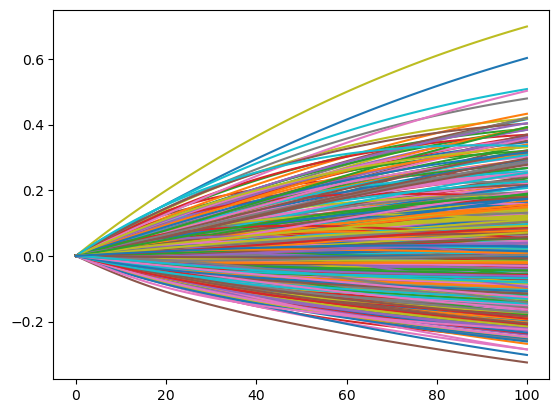

In [18]:
pl.plot(f.temperature[100:,0,:,0] - f.temperature[100,0,:,0]);

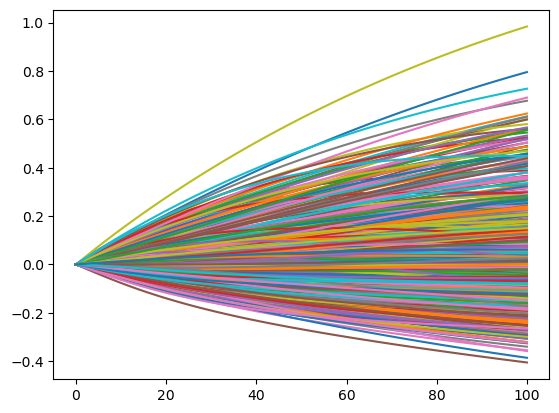

In [19]:
pl.plot(f.temperature[100:,1,:,0] - f.temperature[100,1,:,0]);

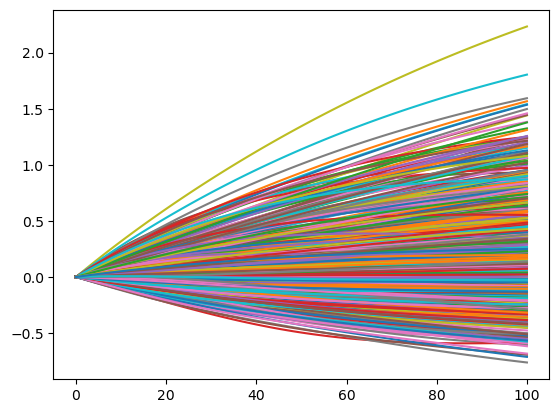

In [20]:
pl.plot(f.temperature[100:,2,:,0] - f.temperature[100,2,:,0]);

[-0.12310475 -0.0310334   0.15905535]
[-0.15094669 -0.02955078  0.2316736 ]
[-0.24980122  0.02972169  0.57904386]


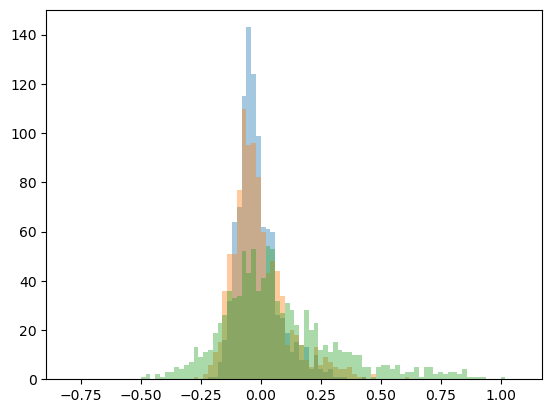

In [21]:
# ZEC50
pl.hist(f.temperature[150,0,:,0] - f.temperature[100,0,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[150,1,:,0] - f.temperature[100,1,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[150,2,:,0] - f.temperature[100,2,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
print(np.percentile(f.temperature[150,0,:,0] - f.temperature[100,0,:,0], (5,50,95)))
print(np.percentile(f.temperature[150,1,:,0] - f.temperature[100,1,:,0], (5,50,95)))
print(np.percentile(f.temperature[150,2,:,0] - f.temperature[100,2,:,0], (5,50,95)))

[-0.19382262 -0.04351351  0.26730807]
[-0.23659956 -0.03606936  0.38829604]
[-0.38800515  0.06067831  0.95394755]


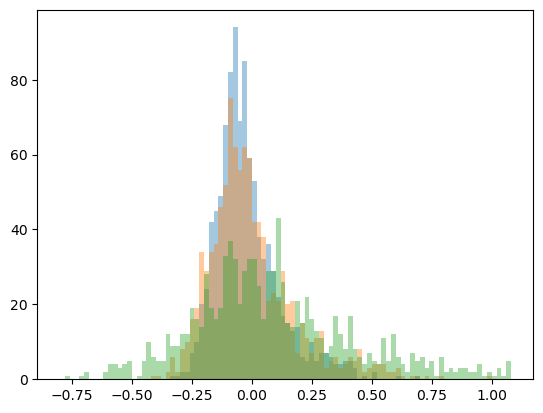

In [22]:
# ZEC100
pl.hist(f.temperature[200,0,:,0] - f.temperature[100,0,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[200,1,:,0] - f.temperature[100,1,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
pl.hist(f.temperature[200,2,:,0] - f.temperature[100,2,:,0], alpha=0.4, bins=np.arange(-0.8, 1.1, 0.02))
print(np.percentile(f.temperature[200,0,:,0] - f.temperature[100,0,:,0], (5,50,95)))
print(np.percentile(f.temperature[200,1,:,0] - f.temperature[100,1,:,0], (5,50,95)))
print(np.percentile(f.temperature[200,2,:,0] - f.temperature[100,2,:,0], (5,50,95)))

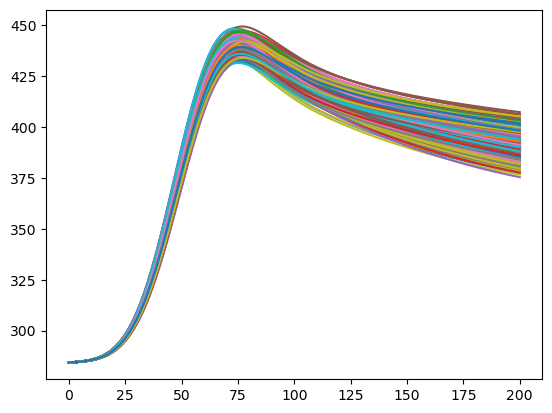

In [23]:
pl.plot(f.concentration[:,0,:,0]);

In [24]:
f.temperature[150,0,12,0] - f.temperature[100,0,12,0]

<xarray.DataArray ()>
array(-0.06214292)
Coordinates:
    scenario  <U16 'esm-bell-750PgC'
    config    int64 11410
    layer     int64 0

In [25]:
f.temperature[150,0,:,0] - f.temperature[100,0,:,0]

<xarray.DataArray (config: 1001)>
array([ 0.03851682, -0.0135535 , -0.03956905, ...,  0.05735498,
       -0.05196259,  0.02810379])
Coordinates:
    scenario  <U16 'esm-bell-750PgC'
  * config    (config) int64 394 1850 1923 2317 ... 1493662 1495531 1495865
    layer     int64 0

In [26]:
df = pd.DataFrame(
    np.array([
        f.temperature[148,0,:,0] - f.temperature[100,0,:,0], 
        f.temperature[150,0,:,0] - f.temperature[100,0,:,0], 
        f.temperature[200,0,:,0] - f.temperature[100,0,:,0],
        f.temperature[150,1,:,0] - f.temperature[100,1,:,0], 
        f.temperature[200,1,:,0] - f.temperature[100,1,:,0],
    ]).T,
    index=fair_params_df.index, 
    columns=['zec48_750', 'zec50_750', 'zec100_750', 'zec50_1000', 'zec100_1000']
)

In [27]:
os.makedirs('../results/', exist_ok=True)
df.to_csv('../results/zec_esm-bell.csv')